# Examples of fitting and data pipelining with PyHyperScattering

### This notebook aims to show a few of the features that PyHyper enables for straightforward processing of RSoXS data.

### We're going to skip a lot of the loading/reduction steps and reconstitute an array of previously-reduced data; see other tutorials for those steps

Begin with a few imports and similar examples.  The Napari import may fail if you aren't set up.

You also need to clone the PyHyper repo to the current directory

In [63]:
import sys
sys.path.append("./PyHyperScattering/PyHyperScattering/")

#from ALS11012RSoXSLoader import ALS11012RSoXSLoader
from SST1RSoXSLoader import SST1RSoXSLoader

from PFEnergySeriesIntegrator import PFEnergySeriesIntegrator
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

%gui qt5
import napari

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This next cell loads some data from SST-1 in a pickle file. Note that you should only load pickle files from sources you trust, as they can result in arbitrary code execution.

We generate int_stack, a list of xarrays, and data_idx, a key from those indices.  (This might be formalized as a conceptual "data catalog" at some point in the future)

In [65]:
#to reconstitute int_stack from pickle:
import pickle
int_stack =  pickle.load(open( "SST1_Dec20_int_stack.p", "rb" ) )

data_idx = []

for i,x in enumerate(int_stack):
    print(f'{i}: {x.sample_name} @ energy {float(np.min(x.energy))}, pol: {float(x.polarization[0])}')
    data_idx.append([i,x.sample_name,float(np.min(x.energy)),float(x.polarization[0])])
    
data_idx = pd.DataFrame(data_idx,columns=['num','sample','energy','pol'])

0: TPPD30G @ energy 270.0, pol: 90.0
1: TP30G @ energy 270.0, pol: 0.0
2: TP100F @ energy 270.0, pol: 0.0
3: TPPD30F @ energy 270.0, pol: 90.0
4: TO30G @ energy 270.0, pol: 90.0
5: TP30F @ energy 270.0, pol: 0.0
6: TPPD30G @ energy 270.0, pol: 0.0
7: TP100F @ energy 270.0, pol: 0.0
8: TP30F @ energy 270.0, pol: 90.0
9: TO30F @ energy 270.0, pol: 0.0
10: TP30F @ energy 510.0, pol: 90.0
11: TP30F @ energy 510.0, pol: 0.0
12: TO30G @ energy 510.0, pol: 90.0
13: TP30G @ energy 510.0, pol: 0.0
14: TM30G @ energy 510.0, pol: 90.0
15: TPPD30G @ energy 510.0, pol: 0.0
16: TM30G @ energy 270.0, pol: 90.0
17: TO30F @ energy 510.0, pol: 0.0
18: TPPD30G @ energy 510.0, pol: 90.0
19: TP100F @ energy 510.0, pol: 0.0
20: TPPD30F @ energy 510.0, pol: 90.0
21: TM30F @ energy 270.0, pol: 90.0
22: TPPD30F @ energy 270.0, pol: 0.0
23: TO30G @ energy 270.0, pol: 0.0
24: TP30G @ energy 270.0, pol: 90.0
25: TP100F @ energy 270.0, pol: 90.0
26: TP100G @ energy 270.0, pol: 0.0
27: TM30F @ energy 270.0, pol: 0.

We can pick out any entry from that catalog and get the corresponding xarray...

In [66]:
sel = int_stack[16]
sel

<xarray.DataArray (system: 61, chi: 360, q: 500)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * chi           (chi) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * system        (system) MultiIndex
  - energy        (system) float64 305.0 297.0 282.0 286.0 ... 302.0 298.0 281.0
  - polarization  (system) int64 90 90 90 90 90 90 90 ... 90 90 90 90 90 90 90
  * q             (q) float64 1.261e-05 3.783e-05 6.305e-05 ... 0.01257 0.0126
Attributes:
    exposure:       2.0
    energy:         305.0
    polarization:   90
    sam_x:          4.0639
    sam_y:          -168.3025
    sam_z:          0.0
    sam_th:         180.0
    sample_name:    TM30G
    rsoxs_config:   saxs
    beamcenter_x:   489.86
    beamcenter_y:   490.75
    sdd:            521.8
    wavelength:     4.065055737704918e-09
    seq_num:        53
    sampleid:       21790
    dist:           0.5217999999999999
    pixel1:         5.9999999999999995e-05
    pixel2:         5.9999999999999995e-05
    poni1:          0.029445
    poni2:          0.029391599999999997
    rot1:           0
    rot2:           0
    rot3:           0
    dims_unpacked:  ['energy', 'polarization']

And, as a refresher, we can further slice and plot that xarray using the command syntax.

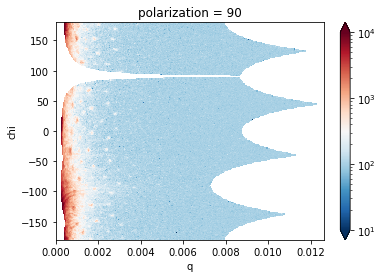

In [67]:
sel.sel(energy=284.25).plot(norm=LogNorm(10,1e4))

Or even do sophisticated sequences of slicing-integration-slicing to produce dimensionally reduced plots.

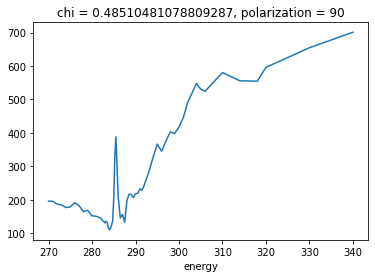

In [69]:
sel.sel(q=slice(0.0018,0.0025)).mean('q').sel(chi=0,method='nearest').unstack('system').plot()

## Part I: How good is Anisotropic Ratio, anyway?

In this section we're going to look at how we compute a simple derived quantity, the anisotropic ratio, and play with some other ways to calculate it.

The simple version is (para - perp) + (para + perp) where para and perp are slices of the same dataset.  This becomes pretty easy to pipeline in!

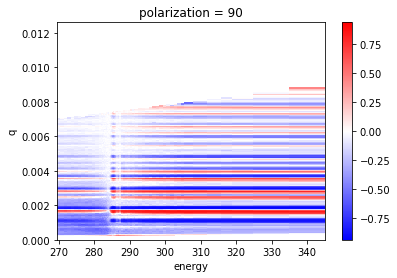

In [76]:
para = sel.sel(chi=slice(-10,10)).mean('chi') 
perp = sel.sel(chi=slice(-100,-80)).mean('chi')
ar = (para - perp) / (para+perp)
ar.unstack('system').plot(cmap='bwr')

Whoa!! This is oriented like crazy, right?  Let's look at a raw scan to see...

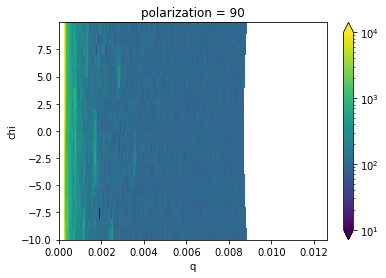

In [74]:
para.sel(energy=284).plot(norm=LogNorm(10,1e4))

Hmmm...  not much orientation there... what about the two slices?

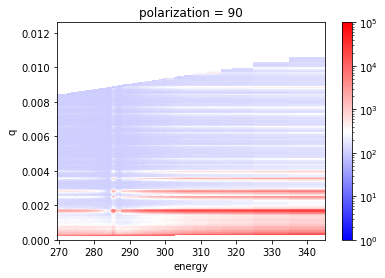

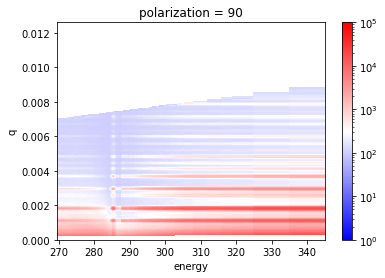

In [9]:
para.unstack('system').plot(norm=LogNorm(1,1e5),cmap='bwr')
plt.figure()
perp.unstack('system').plot(norm=LogNorm(1,1e5),cmap='bwr')

These look pretty comparable.  Seems like there is an artifact, where a peak is being clipped in one chi-slice but not the other.  

To try to deal this, let's calculate AR using the two polarizations at which the sample was measured.  To do that, we go back to the catalog...

this next query uses a paradigm that will come up again and again - groupby - which basically chunks a pandas frame or xarray into individual elements.  So we're going to first chunk by sample name, then by energy range, to get the pairs, see below:

In [10]:
for entry in data_idx.groupby('sample'):
    gbe = entry[1].groupby('energy')
    for item in gbe:
        print(item)

(270.0,     num sample  energy   pol
21   21  TM30F   270.0  90.0
27   27  TM30F   270.0   0.0)
(510.0,     num sample  energy   pol
32   32  TM30F   510.0   0.0
34   34  TM30F   510.0  90.0)
(270.0,     num sample  energy   pol
16   16  TM30G   270.0  90.0
30   30  TM30G   270.0   0.0)
(510.0,     num sample  energy   pol
14   14  TM30G   510.0  90.0
33   33  TM30G   510.0   0.0)
(270.0,     num sample  energy   pol
9     9  TO30F   270.0   0.0
28   28  TO30F   270.0  90.0)
(510.0,     num sample  energy   pol
17   17  TO30F   510.0   0.0
31   31  TO30F   510.0  90.0)
(270.0,     num sample  energy   pol
4     4  TO30G   270.0  90.0
23   23  TO30G   270.0   0.0)
(510.0,     num sample  energy   pol
12   12  TO30G   510.0  90.0
36   36  TO30G   510.0   0.0)
(270.0,     num  sample  energy   pol
2     2  TP100F   270.0   0.0
7     7  TP100F   270.0   0.0
25   25  TP100F   270.0  90.0)
(510.0,     num  sample  energy   pol
19   19  TP100F   510.0   0.0
40   40  TP100F   510.0  90.0)
(270

So now we can pick out the first two - TM30F - and slice them as before

In [77]:
sel0 = int_stack[27]
para_0 = sel0.sel(chi=slice(-10,10)).mean('chi').unstack('system').drop('polarization')
perp_0 = sel0.sel(chi=slice(-100,-80)).mean('chi').unstack('system').drop('polarization')
sel90 = int_stack[21]
para_90 = sel90.sel(chi=slice(-10,10)).mean('chi').unstack('system').drop('polarization')
perp_90 = sel90.sel(chi=slice(-100,-80)).mean('chi').unstack('system').drop('polarization')



Now we can plot the conventional AR from the 0 degree image:

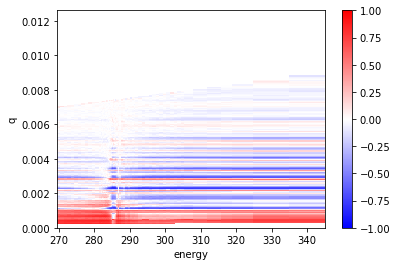

In [78]:
conv_ar_0 = (para_0 - perp_0) / (para_0+perp_0)
conv_ar_0.plot(vmin=-1,vmax=1,cmap='bwr')

Or we can compute the local AR using either the parallel or perpendicular measurements only.  Not much orientation here.  Hmm.

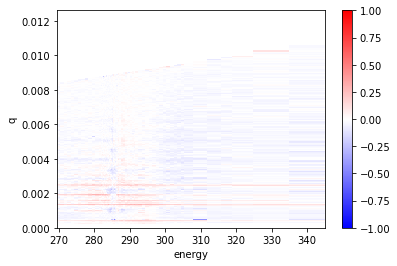

In [79]:
local_ar_para = (para_0 - para_90) / (para_0 + para_90)
local_ar_para.plot(vmin=-1,vmax=1,cmap='bwr')

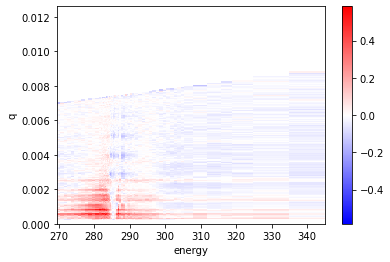

In [80]:
local_ar_perp = (perp_0 - perp_90) / (perp_0 + perp_90)
local_ar_perp.plot(cmap='bwr')

Looking closely at just one q-slice, there is a bit of anisotropy, and I think it's real... 

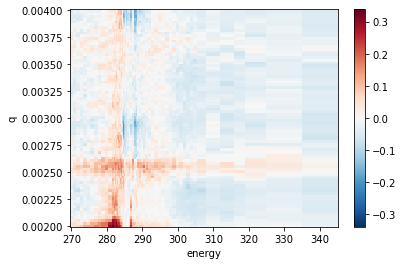

In [15]:
local_ar_perp.sel(q=slice(0.002,0.004)).plot()

but with this data, we should be able to get the anisotropy as a function of rotation on the sample.  Here we go...

In [1]:
sel0l = sel0.unstack('system').drop('polarization')
sel90l = sel90.unstack('system').drop('polarization')

NameError: name 'sel0' is not defined

In [18]:
#Normalize by int at one energy

norm_energy = 310

#normalize each to their intensity at that energy...

sel0l = sel0l / sel0l.sel(energy=norm_energy)
sel90l = sel90l / sel90l.sel(energy=norm_energy)


ar_holistic = (sel0l - sel90l) / (sel0l + sel90l)

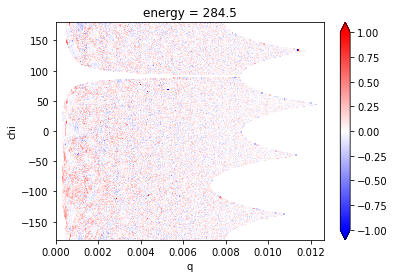

In [83]:
ar_holistic.sel(energy=284.5).plot(vmin=-1,vmax=1,cmap='bwr')

## Part II: Fitting examples

In this part, we're going to show how we can use groupby (split-apply-combine) to do local fits to a series of slices, and use that do pull peak intensities out of background (in a simple example).

Let's import a fit function that comes with PyHyper and load up some data...

In [84]:
import Fitting
from Fitting import fit_lorentz_bg



In [85]:
fit_example = int_stack[16]

In [23]:
fit_example

<xarray.DataArray (system: 61, chi: 360, q: 500)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * chi           (chi) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * system        (system) MultiIndex
  - energy        (system) float64 305.0 297.0 282.0 286.0 ... 302.0 298.0 281.0
  - polarization  (system) int64 90 90 90 90 90 90 90 ... 90 90 90 90 90 90 90
  * q             (q) float64 1.261e-05 3.783e-05 6.305e-05 ... 0.01257 0.0126
Attributes:
    exposure:       2.0
    energy:         305.0
    polarization:   90
    sam_x:          4.0639
    sam_y:          -168.3025
    sam_z:          0.0
    sam_th:         180.0
    sample_name:    TM30G
    rsoxs_config:   saxs
    beamcenter_x:   489.86
    beamcenter_y:   490.75
    sdd:            521.8
    wavelength:     4.065055737704918e-09
    seq_num:        53
    sampleid:       21790
    dist:           0.5217999999999999
    pixel1:         5.9999999999999995e-05
    pixel2:         5.9999999999999995e-05
    poni1:          0.029445
    poni2:          0.029391599999999997
    rot1:           0
    rot2:           0
    rot3:           0
    dims_unpacked:  ['energy', 'polarization']

In the end, most fits can be packaged into a one-line command.  That's a reasonable way to run, but not great for learning.  So we're going to show the one-liner, and then step through what happens.

In [ ]:
#this is the one-liner that we're going to break down

fit_example_results = (fit_example
       #.coarsen(chi=10).mean()      #you can either coarsen chi (where number is an integer number of bins
                                     #over which to do a moving average), or
       .sel(chi=0,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .stack(echi=['energy','chi']) 
       .sel(q=slice(0.0018,0.0025))
       .groupby('echi')
       .map(fit_lorentz_bg,guess=[0,0,0.0002,2e-8],pos_int_override=True)
       .unstack('echi'))

For simplicity/time's sake, we're going to just do a single chi, though you could also coarsen it as above.   That results in about 3500 fits in this example, iirc.

We start by punching out the chi point and polarization we need, and checking out the data in that slice.

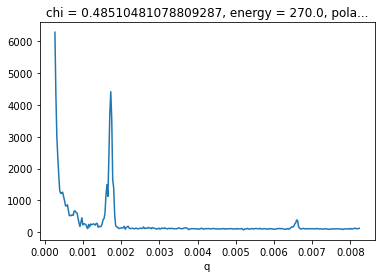

In [89]:
ires = fit_example.sel(chi=0,method='nearest').unstack('system').sel(polarization=90) 
#ires = fit_example.coarsen(chi=10).mean().unstack('system').sel(polarization=90)
ires.sel(energy=270).plot()

We then stack the energy axis into a multiindex so that chunking will work - this could encompass chi as well as in the commented-out block.

We than punch out the area around the peak using a slice selector.

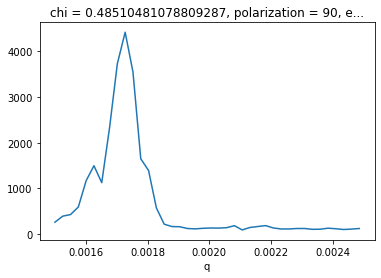

In [90]:
ires = ires.stack(echi=['energy'])#,'chi'])
ires = ires.sel(q=slice(0.0015,0.0025))
ires.sel(energy=270).plot(x='q')

OK, now we get into the meaty part.  We use .groupby to make a groupby object, which is an iterator that will split the array into groups and then sequentially process them.

In [91]:
ires = ires.groupby('echi')
ires

DataArrayGroupBy, grouped over 'echi' 
61 groups with labels (270.0,), (271.0,), ..., (340.0,).

We're next going to use the map function which basically just runs a function on each element of the groupby, then stuffs the results into a new xarray with the same indices.

The function is pyhyper's fit_lorentz_bg, which is pretty rudimentary:
```
def fit_lorentz_bg(x,guess=None,pos_int_override=False):
    # example guess: [500.,0.00665,0.0002,0] [int, q, width, bg]
    if guess == None:
        guess = [500.,0.00665,0.0002,0]
        pos_int_override=True
    if pos_int_override:
        guess[1] = np.median(x.coords['q'])
        guess[0] = x.sel(q=guess[1],method='nearest')
    print(f"Starting fit on {x.coords}")
    try:
        coeff, var_matrix = scipy.optimize.curve_fit(lorentz_w_flat_bg,x.coords['q'],x.data,p0=guess)
    except RuntimeError:
        print("Fit failed to converge")
        return xr.DataArray(data=np.nan,coords=x.coords)
    print(f"Fit completed, coeff = {coeff}")
    return xr.DataArray(data=coeff[0],coords=x.coords)
```

So the arguments are a a guess and a flag that tells the fitter whether or not to override the position/intensity with reasonable guesses from the input


In [92]:
ires = ires.map(fit_lorentz_bg,guess=[0,0,0.0002,2e-8],pos_int_override=True)

Starting fit on Coordinates:
    chi           float64 0.4851
  * q             (q) float64 0.001501 0.001526 0.001551 ... 0.002459 0.002484
    polarization  int64 90
    echi          object (270.0,)
Fit completed, coeff = [4.46812321e+03 1.72309861e-03 4.93055154e-05 2.00000000e-08]
Starting fit on Coordinates:
    chi           float64 0.4851
  * q             (q) float64 0.001501 0.001526 0.001551 ... 0.002459 0.002484
    polarization  int64 90
    echi          object (271.0,)


/opt/miniconda3/envs/rsoxs/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fit completed, coeff = [4.51346585e+03 1.72393220e-03 4.83744280e-05 2.00000000e-08]
Starting fit on Coordinates:
    chi           float64 0.4851
  * q             (q) float64 0.001501 0.001526 0.001551 ... 0.002459 0.002484
    polarization  int64 90
    echi          object (272.0,)
Fit completed, coeff = [4.27076017e+03 1.72549388e-03 4.78105782e-05 2.00000000e-08]
Starting fit on Coordinates:
    chi           float64 0.4851
  * q             (q) float64 0.001501 0.001526 0.001551 ... 0.002459 0.002484
    polarization  int64 90
    echi          object (273.0,)
Fit completed, coeff = [4.09931511e+03 1.72246181e-03 5.07842523e-05 2.00000000e-08]
Starting fit on Coordinates:
    chi           float64 0.4851
  * q             (q) float64 0.001501 0.001526 0.001551 ... 0.002459 0.002484
    polarization  int64 90
    echi          object (274.0,)
Fit completed, coeff = [3.70413577e+03 1.72115156e-03 5.52841324e-05 2.00000000e-08]
Starting fit on Coordinates:
    chi           float64

Wow, that was some computation!  Let's look at the results...

In [93]:
ires

<xarray.DataArray (q: 40, echi: 61)>
array([[ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       ...,
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772]])
Coordinates:
    chi           float64 0.4851
  * q             (q) float64 0.001501 0.001526 0.001551 ... 0.002459 0.002484
    polarization  int64 90
  * echi          (echi) MultiIndex
  - energy        (echi) float64 270.0 271.0 272.0 273.0 ... 320.0 330.0 340.0

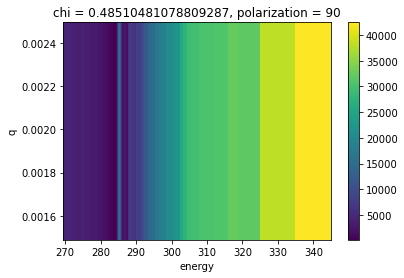

In [95]:
ires.plot()

Oops, looks like we still have q, and still have echi as a multiindex.  Let's take care of those in two steps...

In [94]:
ires = ires.unstack('echi')
ires

<xarray.DataArray (q: 40, energy: 61)>
array([[ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       ...,
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772],
       [ 4468.12320888,  4513.46585302,  4270.76017208, ...,
        31893.92938684, 38243.44773907, 42445.79540772]])
Coordinates:
    chi           float64 0.4851
  * q             (q) float64 0.001501 0.001526 0.001551 ... 0.002459 0.002484
    polarization  int64 90
  * energy        (energy) float64 270.0 271.0 272.0 273.0 ... 320.0 330.0 340.0

So here's the peak intensity vs energy, from our Lorentz fit....

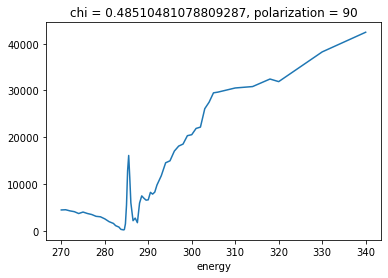

In [96]:
ires.mean('q').plot()

And for comparison, here's the equivalent using total-integrated intensity.  Subtly different!

In [97]:
comp_res = fit_example.sel(chi=0,method='nearest').unstack('system').sel(polarization=90).sel(q=slice(0.0018,0.0025)).mean('q')

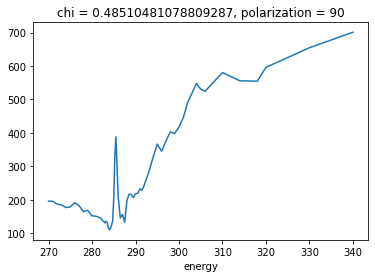

In [98]:
comp_res.plot()